Split the GPT

1 -1.6047345553367809 0.48121474776572054 24


c:\Users\ojimenezb\OneDrive - Indra\Documentos\Personal\VSC\T\TFG_ADE\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ojimenezb\OneDrive - Indra\Documentos\Personal\VSC\T\TFG_ADE\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ojimenezb\OneDrive - Indra\Documentos\Personal\VSC\T\TFG_ADE\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


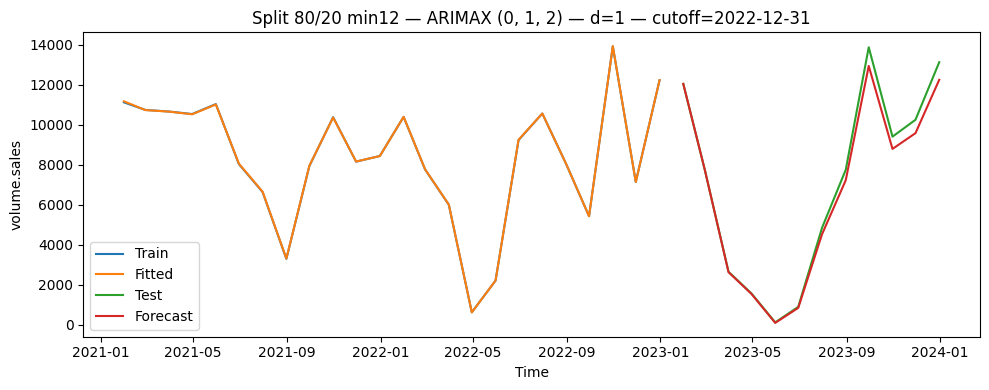

d detectado: 1 | ADF p-valor: 0.481215
Orden (p,d,q): (0, 1, 2)
Exógenas: ['unit.sales', 'value.sales', 'price']
MAE: 338.212 | RMSE: 487.048 | MAPE(%): 5.63
CSV: arimax_split_80_20_min12_predictions.csv


In [3]:
# -*- coding: utf-8 -*-
# ARIMAX con exógenas — Split 80/20 con mínimo 12 en test

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Configura esto ===
PATH = "C:\\Users\\ojimenezb\\OneDrive - Indra\\Documentos\\Personal\\VSC\\T\\TFG_ADE\\data\\data_GPT.xlsx"  
DATE_COL = "date"
TARGET_COL = "volume.sales"
FILTER = {                 # Serie concreta (cámbialo si quieres otra)
    "supermarket": "supermarket-A",
    "variant": "flavoured",
    "pack.size": "0 - 350 GR",
}

def adf_detailed(s):
    s = s.dropna().astype(float)
    stat, pval, *_ = adfuller(s, autolag="AIC")
    d = 0 if pval < 0.05 else 1
    return d, float(stat), float(pval), int(len(s))

def choose_exog(train_df, target, pref=None, exclude=(), k_auto=3):
    chosen = []
    if pref:
        for c in pref:
            if c in train_df.columns and c not in exclude and pd.api.types.is_numeric_dtype(train_df[c]):
                chosen.append(c)
    if not chosen:
        num_cols = [c for c in train_df.columns
                    if c not in exclude
                    and pd.api.types.is_numeric_dtype(train_df[c])
                    and train_df[c].nunique() > 5]
        if num_cols:
            corr = train_df[num_cols].corrwith(train_df[target]).abs().sort_values(ascending=False)
            chosen = list(corr.head(k_auto).index)
    return chosen

def best_order(y, X, d, max_p=2, max_q=2):
    best = None
    for p in range(max_p+1):
        for q in range(max_q+1):
            if (p, d, q) == (0, 0, 0):
                continue
            try:
                res = SARIMAX(y, exog=X, order=(p, d, q),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if best is None or res.aic < best["aic"]:
                    best = {"order": (p, d, q), "aic": res.aic, "res": res}
            except Exception:
                continue
    return best

def eval_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / np.maximum(1e-9, np.abs(y_true)))).mean() * 100.0
    return mae, rmse, mape

def safe_name(s: str) -> str:
    for ch in [" ", "(", ")", "/", "\\", ":"]:
        s = s.replace(ch, "_")
    return s

def main():
    # Carga + filtro + orden temporal
    df = pd.read_excel(PATH)
    for k, v in FILTER.items():
        df = df[df[k] == v]
    df = df.copy()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

    n = len(df)
    if n < 20:
        raise RuntimeError("Muy pocos datos para hacer split y validar.")

    # === Split A: 80/20 con mínimo 12 en test ===
    test_size = max(12, int(round(0.2 * n)))
    train = df.iloc[:-test_size] if n > test_size else df.iloc[:-1]
    test  = df.iloc[-test_size:] if n > test_size else df.iloc[-1:]

    # d vía ADF en train
    d, adf_stat, adf_pval, n_train = adf_detailed(train[TARGET_COL])
    print(d, adf_stat, adf_pval, n_train)

    # Exógenas
    exclude_cols = {TARGET_COL, DATE_COL, "supermarket", "variant", "pack.size"}
    pref = ["unit.sales", "value.sales", "price"]
    exog_cols = choose_exog(train, TARGET_COL, pref, exclude=exclude_cols, k_auto=3)

    # Matrices
    y_tr = train[TARGET_COL].astype(float)
    X_tr = train[exog_cols].astype(float) if exog_cols else None
    y_te = test[TARGET_COL].astype(float)
    X_te = test[exog_cols].astype(float) if exog_cols else None

    # Orden (p,q)
    best = best_order(y_tr, X_tr, d=d, max_p=2, max_q=2)
    if best is None:
        raise RuntimeError("No se pudo ajustar un ARIMAX con las combinaciones probadas.")
    order, res = best["order"], best["res"]

    # Fitted + Forecast
    fitted_tr = res.predict(start=y_tr.index[0], end=y_tr.index[-1], exog=X_tr)
    fc = res.get_forecast(steps=len(y_te), exog=X_te)
    fc_mean = pd.Series(fc.predicted_mean, index=y_te.index)

    # Métricas
    mae, rmse, mape = eval_forecast(y_te, fc_mean)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(train[DATE_COL], y_tr, label="Train")
    plt.plot(train[DATE_COL], fitted_tr, label="Fitted")
    plt.plot(test[DATE_COL], y_te, label="Test")
    plt.plot(test[DATE_COL], fc_mean, label="Forecast")
    cutoff = train[DATE_COL].iloc[-1].date()
    plt.title(f"Split 80/20 min12 — ARIMAX {order} — d={d} — cutoff={cutoff}")
    plt.xlabel("Time")
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # CSV
    out_csv = f"arimax_{safe_name('split_80_20_min12')}_predictions.csv"
    pd.DataFrame({
        "time": pd.concat([train[DATE_COL], test[DATE_COL]]).values,
        "set": (["train"] * len(train)) + (["test"] * len(test)),
        "y_true": pd.concat([y_tr, y_te]).values,
        "y_hat": pd.concat([fitted_tr, fc_mean]).reindex(pd.concat([y_tr, y_te]).index).values
    }).to_csv(out_csv, index=False)

    print("d detectado:", d, "| ADF p-valor:", round(adf_pval, 6))
    print("Orden (p,d,q):", order)
    print("Exógenas:", exog_cols)
    print("MAE:", round(mae,3), "| RMSE:", round(rmse,3), "| MAPE(%):", round(mape,2))
    print("CSV:", out_csv)

if __name__ == "__main__":
    main()


Split mio

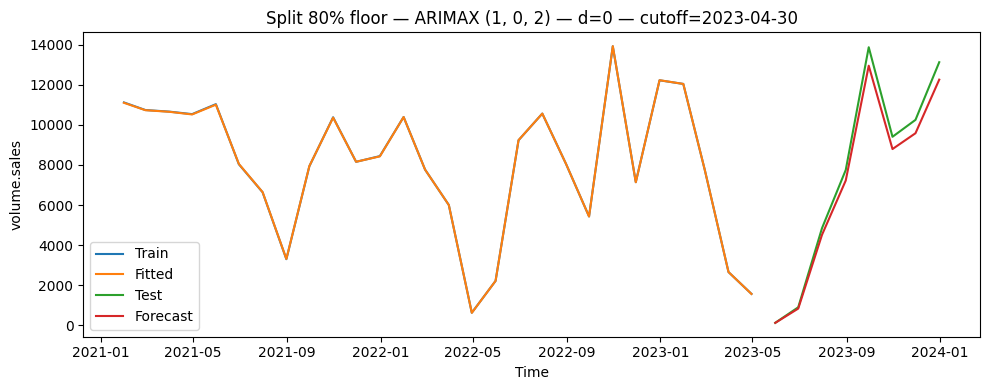

d detectado: 0 | ADF p-valor: 0.040418
Orden (p,d,q): (1, 0, 2)
Exógenas: ['unit.sales', 'value.sales', 'price']
MAE: 499.49 | RMSE: 593.251 | MAPE(%): 6.24
CSV: arimax_split_80pct_floor_predictions.csv


In [6]:
# -*- coding: utf-8 -*-
# ARIMAX con exógenas — Split 80% floor para train (sin mínimo de test)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Configura esto ===
PATH = "C:\\Users\\ojimenezb\\OneDrive - Indra\\Documentos\\Personal\\VSC\\T\\TFG_ADE\\data\\data_GPT.xlsx"  
DATE_COL = "date"
TARGET_COL = "volume.sales"
FILTER = {                 # Serie concreta (cámbialo si quieres otra)
    "supermarket": "supermarket-A",
    "variant": "flavoured",
    "pack.size": "0 - 350 GR",
}

def adf_detailed(s):
    s = s.dropna().astype(float)
    stat, pval, *_ = adfuller(s, autolag="AIC")
    d = 0 if pval < 0.05 else 1
    return d, float(stat), float(pval), int(len(s))

def choose_exog(train_df, target, pref=None, exclude=(), k_auto=3):
    chosen = []
    if pref:
        for c in pref:
            if c in train_df.columns and c not in exclude and pd.api.types.is_numeric_dtype(train_df[c]):
                chosen.append(c)
    if not chosen:
        num_cols = [c for c in train_df.columns
                    if c not in exclude
                    and pd.api.types.is_numeric_dtype(train_df[c])
                    and train_df[c].nunique() > 5]
        if num_cols:
            corr = train_df[num_cols].corrwith(train_df[target]).abs().sort_values(ascending=False)
            chosen = list(corr.head(k_auto).index)
    return chosen

def best_order(y, X, d, max_p=2, max_q=2):
    best = None
    for p in range(max_p+1):
        for q in range(max_q+1):
            if (p, d, q) == (0, 0, 0):
                continue
            try:
                res = SARIMAX(y, exog=X, order=(p, d, q),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                if best is None or res.aic < best["aic"]:
                    best = {"order": (p, d, q), "aic": res.aic, "res": res}
            except Exception:
                continue
    return best

def eval_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / np.maximum(1e-9, np.abs(y_true)))).mean() * 100.0
    return mae, rmse, mape

def safe_name(s: str) -> str:
    for ch in [" ", "(", ")", "/", "\\", ":"]:
        s = s.replace(ch, "_")
    return s

def main():
    # Carga + filtro + orden temporal
    df = pd.read_excel(PATH)
    for k, v in FILTER.items():
        df = df[df[k] == v]
    df = df.copy()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

    n = len(df)
    if n < 20:
        raise RuntimeError("Muy pocos datos para hacer split y validar.")

    # === Split B: 80% floor para train ===
    train_size = int(n * 0.8)
    train = df.iloc[:train_size]
    test  = df.iloc[train_size:]

    # d vía ADF en train
    d, adf_stat, adf_pval, n_train = adf_detailed(train[TARGET_COL])
    # Exógenas
    exclude_cols = {TARGET_COL, DATE_COL, "supermarket", "variant", "pack.size"}
    pref = ["unit.sales", "value.sales", "price"]
    exog_cols = choose_exog(train, TARGET_COL, pref, exclude=exclude_cols, k_auto=3)
    
    # Matrices
    y_tr = train[TARGET_COL].astype(float)
    X_tr = train[exog_cols].astype(float) if exog_cols else None
    y_te = test[TARGET_COL].astype(float)
    X_te = test[exog_cols].astype(float) if exog_cols else None

    # Orden (p,q)
    best = best_order(y_tr, X_tr, d=d, max_p=2, max_q=2)
    if best is None:
        raise RuntimeError("No se pudo ajustar un ARIMAX con las combinaciones probadas.")
    order, res = best["order"], best["res"]

    # Fitted + Forecast
    fitted_tr = res.predict(start=y_tr.index[0], end=y_tr.index[-1], exog=X_tr)
    fc = res.get_forecast(steps=len(y_te), exog=X_te)
    fc_mean = pd.Series(fc.predicted_mean, index=y_te.index)

    # Métricas
    mae, rmse, mape = eval_forecast(y_te, fc_mean)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(train[DATE_COL], y_tr, label="Train")
    plt.plot(train[DATE_COL], fitted_tr, label="Fitted")
    plt.plot(test[DATE_COL], y_te, label="Test")
    plt.plot(test[DATE_COL], fc_mean, label="Forecast")
    cutoff = train[DATE_COL].iloc[-1].date()
    plt.title(f"Split 80% floor — ARIMAX {order} — d={d} — cutoff={cutoff}")
    plt.xlabel("Time")
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # CSV
    out_csv = f"arimax_{safe_name('split_80pct_floor')}_predictions.csv"
    pd.DataFrame({
        "time": pd.concat([train[DATE_COL], test[DATE_COL]]).values,
        "set": (["train"] * len(train)) + (["test"] * len(test)),
        "y_true": pd.concat([y_tr, y_te]).values,
        "y_hat": pd.concat([fitted_tr, fc_mean]).reindex(pd.concat([y_tr, y_te]).index).values
    }).to_csv(out_csv, index=False)

    print("d detectado:", d, "| ADF p-valor:", round(adf_pval, 6))
    print("Orden (p,d,q):", order)
    print("Exógenas:", exog_cols)
    print("MAE:", round(mae,3), "| RMSE:", round(rmse,3), "| MAPE(%):", round(mape,2))
    print("CSV:", out_csv)

if __name__ == "__main__":
    main()


Ranking de cual es el mejor modelo, comparando todas las series

In [5]:
# -*- coding: utf-8 -*-
# Recorre todas las series (supermarket, variant, pack.size),
# ajusta ARIMAX con exógenas y evalúa dos splits:
#  - Split A: 80/20 con mínimo 12 en test
#  - Split B: 80% floor para train
# Genera un ranking por métricas y guarda resultados a CSV.

import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ========= CONFIG =========
PATH = "C:\\Users\\ojimenezb\\OneDrive - Indra\\Documentos\\Personal\\VSC\\T\\TFG_ADE\\data\\data_GPT.xlsx"      # Cambia la ruta si hace falta
DATE_COL = "date"
TARGET_COL = "volume.sales"
KEYS = ["supermarket", "variant", "pack.size"]   # columnas que definen cada serie

# Exógenas preferidas si existen; si no, se auto-seleccionan por correlación
PREFERRED_EXOG = ["unit.sales", "value.sales", "price"]

# Métrica para ranking por split (elige "MAPE_%", "RMSE" o "MAE")
RANK_METRIC = "MAPE_%"

# Filtros opcionales:
MIN_TOTAL_POINTS = 20       # descarta series muy cortas
TOP_N_SERIES_BY_LENGTH = None  # ej. 50 para limitar a top 50 por longitud; None = todas
# ==========================

def adf_detailed(s: pd.Series):
    s = s.dropna().astype(float)
    stat, pval, *_ = adfuller(s, autolag="AIC")
    d = 0 if pval < 0.05 else 1
    return d, float(stat), float(pval), int(len(s))

def choose_exog(train_df: pd.DataFrame, target: str, preferred=None, exclude=(), k_auto=3):
    chosen = []
    if preferred:
        for c in preferred:
            if c in train_df.columns and c not in exclude and pd.api.types.is_numeric_dtype(train_df[c]):
                chosen.append(c)
    if not chosen:
        num_cols = [c for c in train_df.columns
                    if c not in exclude
                    and pd.api.types.is_numeric_dtype(train_df[c])
                    and train_df[c].nunique() > 5]
        if num_cols:
            corr = train_df[num_cols].corrwith(train_df[target]).abs().sort_values(ascending=False)
            chosen = list(corr.head(k_auto).index)
    return chosen

def best_order(y, X, d, max_p=2, max_q=2):
    best = None
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if (p, d, q) == (0, 0, 0):
                continue
            try:
                res = SARIMAX(y, exog=X, order=(p, d, q),
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                aic = res.aic
                if best is None or aic < best["aic"]:
                    best = {"order": (p, d, q), "aic": aic, "res": res}
            except Exception:
                continue
    return best

def eval_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / np.maximum(1e-9, np.abs(y_true)))).mean() * 100.0
    return float(mae), float(rmse), float(mape)

def safe_name(s: str) -> str:
    for ch in [" ", "(", ")", "/", "\\", ":", ",", "=", "|"]:
        s = s.replace(ch, "_")
    return s

def split_A(df: pd.DataFrame):
    """80/20 con mínimo 12 en test"""
    n = len(df)
    test_size = max(12, int(round(0.2 * n)))
    train = df.iloc[:-test_size] if n > test_size else df.iloc[:-1]
    test  = df.iloc[-test_size:] if n > test_size else df.iloc[-1:]
    return train, test

def split_B(df: pd.DataFrame):
    """80% floor para train"""
    n = len(df)
    train_size = int(n * 0.8)
    train = df.iloc[:train_size]
    test  = df.iloc[train_size:]
    return train, test

def run_one_series(work: pd.DataFrame, series_id: dict, split_name: str, split_fn):
    """Ajusta y evalúa una serie para un método de split."""
    # Orden temporal y split
    work = work.sort_values(DATE_COL).reset_index(drop=True)
    train, test = split_fn(work)

    # ADF en train -> d
    d, adf_stat, adf_pval, n_train = adf_detailed(train[TARGET_COL])

    # Exógenas
    exclude_cols = {TARGET_COL, DATE_COL, *[k for k in KEYS if k in work.columns]}
    exog_cols = choose_exog(train, TARGET_COL, PREFERRED_EXOG, exclude=exclude_cols, k_auto=3)

    # Datos
    y_tr = train[TARGET_COL].astype(float)
    y_te = test[TARGET_COL].astype(float)
    X_tr = train[exog_cols].astype(float) if exog_cols else None
    X_te = test[exog_cols].astype(float) if exog_cols else None

    # Orden (p,q) con AIC
    best = best_order(y_tr, X_tr, d=d, max_p=2, max_q=2)
    if best is None:
        return {
            **series_id, "split": split_name, "error": "No ARIMAX found",
            "n_total": len(work), "train": len(train), "test": len(test),
        }
    order, res = best["order"], best["res"]

    # Predicción
    fitted_tr = res.predict(start=y_tr.index[0], end=y_tr.index[-1], exog=X_tr)
    fc = res.get_forecast(steps=len(y_te), exog=X_te)
    fc_mean = pd.Series(fc.predicted_mean, index=y_te.index)

    # Métricas
    mae, rmse, mape = eval_forecast(y_te, fc_mean)

    out = {
        **series_id,
        "split": split_name,
        "n_total": len(work),
        "train": len(train),
        "test": len(test),
        "cutoff": str(train[DATE_COL].iloc[-1].date()) if len(train) else None,
        "d": d,
        "adf_pval": round(adf_pval, 6),
        "order": order,
        "exog": ",".join(exog_cols) if exog_cols else "",
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "MAPE_%": round(mape, 4),
        "error": "",
    }
    return out

def main():
    # Carga
    df = pd.read_excel(PATH)
    if DATE_COL not in df.columns or TARGET_COL not in df.columns:
        raise RuntimeError(f"No encuentro {DATE_COL!r} o {TARGET_COL!r} en el Excel.")

    # Normaliza fecha
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL])

    # Comprueba keys presentes
    keys_present = [k for k in KEYS if k in df.columns]
    if not keys_present:
        # Si no hay keys, trata todo como una serie global
        keys_present = []

    # Lista de series a procesar
    if keys_present:
        sizes = df.groupby(keys_present, dropna=False).size().sort_values(ascending=False)
        series_list = sizes.reset_index().rename(columns={0: "count"})
        if TOP_N_SERIES_BY_LENGTH is not None:
            series_list = series_list.head(TOP_N_SERIES_BY_LENGTH)
    else:
        series_list = pd.DataFrame([{**{k: "<global>" for k in KEYS}, "count": len(df)}])

    results = []

    for idx, row in series_list.iterrows():
        # Construir filtro de la serie
        series_filter = {k: row[k] for k in KEYS if k in df.columns}
        label = " | ".join([f"{k}={series_filter[k]}" for k in series_filter]) if series_filter else "<global>"
        sub = df.copy()
        for k, v in series_filter.items():
            sub = sub[sub[k] == v]
        sub = sub.sort_values(DATE_COL).reset_index(drop=True)

        if len(sub) < MIN_TOTAL_POINTS:
            results.append({**series_filter, "split": "SKIP", "n_total": len(sub), "error": "short_series"})
            print(f"[SKIP] {label} -> solo {len(sub)} puntos.")
            continue

        # Split A
        try:
            outA = run_one_series(sub, series_filter, "Split_80_20_min12", split_A)
            results.append(outA)
            print(f"[OK]  {label}  A -> {outA['order']}, d={outA.get('d')}, MAPE={outA.get('MAPE_%')}")
        except Exception as e:
            results.append({**series_filter, "split": "Split_80_20_min12", "n_total": len(sub), "error": str(e)})
            print(f"[ERR] {label}  A -> {e}")

        # Split B
        try:
            outB = run_one_series(sub, series_filter, "Split_80pct_floor", split_B)
            results.append(outB)
            print(f"[OK]  {label}  B -> {outB['order']}, d={outB.get('d')}, MAPE={outB.get('MAPE_%')}")
        except Exception as e:
            results.append({**series_filter, "split": "Split_80pct_floor", "n_total": len(sub), "error": str(e)})
            print(f"[ERR] {label}  B -> {e}")

    res_df = pd.DataFrame(results)

    # Ranking por split
    ranked = []
    for split_name in ["Split_80_20_min12", "Split_80pct_floor"]:
        sub = res_df[(res_df["split"] == split_name) & (res_df["error"] == "")]
        if not sub.empty:
            sub = sub.sort_values(RANK_METRIC, ascending=True).reset_index(drop=True)
            sub["rank"] = np.arange(1, len(sub) + 1)
            ranked.append(sub)
    if ranked:
        ranked_df = pd.concat(ranked, ignore_index=True)
    else:
        ranked_df = pd.DataFrame()

    # Guardados
    res_df.to_csv("arimax_all_series_results.csv", index=False)
    if not ranked_df.empty:
        ranked_df.to_csv(f"arimax_ranking_by_{safe_name(RANK_METRIC)}.csv", index=False)

    # Prints finales
    print("\n=== RESUMEN ===")
    print(f"Series procesadas (incluyendo skips): {series_list.shape[0]}")
    print(f"Resultados guardados en: arimax_all_series_results.csv")
    if not ranked_df.empty:
        print(f"Ranking por {RANK_METRIC} guardado en: arimax_ranking_by_{safe_name(RANK_METRIC)}.csv\n")
        for split_name in ["Split_80_20_min12", "Split_80pct_floor"]:
            tmp = ranked_df[ranked_df["split"] == split_name].head(10)
            if tmp.empty: 
                continue
            print(f"Top 5 — {split_name} (por {RANK_METRIC})")
            cols_show = [k for k in KEYS if k in tmp.columns] + ["n_total","train","test","cutoff","d","order","exog","MAE","RMSE","MAPE_%"]
            print(tmp[cols_show].head(5).to_string(index=False))
            print()

if __name__ == "__main__":
    main()




[OK]  supermarket=supermarket-A | variant=flavoured | pack.size=0 - 350 GR  A -> (0, 1, 2), d=1, MAPE=5.633
[OK]  supermarket=supermarket-A | variant=flavoured | pack.size=0 - 350 GR  B -> (1, 0, 2), d=0, MAPE=6.2426
[OK]  supermarket=supermarket-B | variant=vegan | pack.size=0 - 350 GR  A -> (0, 1, 2), d=1, MAPE=0.4419
[OK]  supermarket=supermarket-B | variant=vegan | pack.size=0 - 350 GR  B -> (1, 0, 2), d=0, MAPE=0.9321
[OK]  supermarket=supermarket-D | variant=standard | pack.size=351 - 500 GR  A -> (2, 1, 2), d=1, MAPE=1.577
[OK]  supermarket=supermarket-D | variant=standard | pack.size=351 - 500 GR  B -> (1, 1, 2), d=1, MAPE=0.4728
[OK]  supermarket=supermarket-D | variant=light | pack.size=351 - 500 GR  A -> (0, 1, 2), d=1, MAPE=274.5314
[OK]  supermarket=supermarket-D | variant=light | pack.size=351 - 500 GR  B -> (0, 0, 2), d=0, MAPE=0.6958
[OK]  supermarket=supermarket-D | variant=flavoured | pack.size=0 - 350 GR  A -> (1, 1, 2), d=1, MAPE=2.2384
[OK]  supermarket=supermarket